In [1]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
from qdisk.utils import is_within
from qdisk.plot import ChannelMap, Map
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve_fft
from analysis_utils import FWHM_to_sigma
from mcmc_tools import log_prior, emcee_run_wrapper, plot_corner, plot_walker
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patheffects as pe
from astropy.visualization import ImageNormalize
from mpl_toolkits.axes_grid1 import ImageGrid
from astropy.visualization import AsinhStretch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
lines = ["12CO", "13CO", "C18O", "SO"]
robust = {"12CO": 0.5, "13CO": 0.5, "C18O": 1.0, "SO": 1.0}
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]
vrange = 6

maps = ["M0", "v0", "Fnu"]
cmap_kwargs = {"M0": dict(cmap=eplot.cmap["M0"], vmin=0.0, stretch=AsinhStretch(a=0.1)), "v0": dict(cmap=eplot.cmap["M1"], vmin=vsys-vrange, vmax=vsys+vrange), "Fnu": dict(cmap=eplot.cmap["M8"], vmin=0.0)}
data_scaling_factor = {"M0": 1.0, "v0": 1e-3, "Fnu": 1e3}
cbar_label = {"M0": "mJy beam$^{-1}$ km s$^{-1}$", "v0": "km s$^{-1}$", "Fnu": "K"}

/home/yamato/Project/eDisk/firstlook_L1489IRS/analysis_utils.py:195: RuntimeWarning: divide by zero encountered in true_divide
  T = h * nu / k_B / np.log(1 + 2 * h * nu**3 / (c**2 * T))


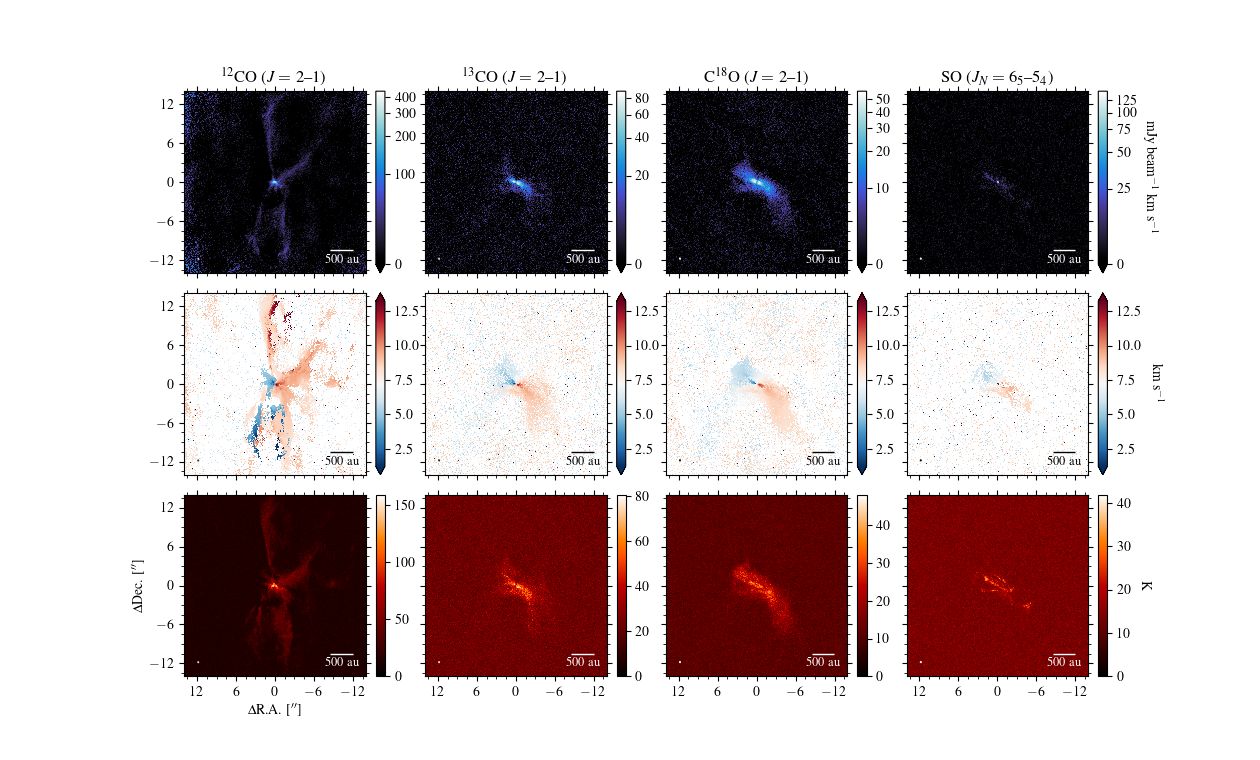

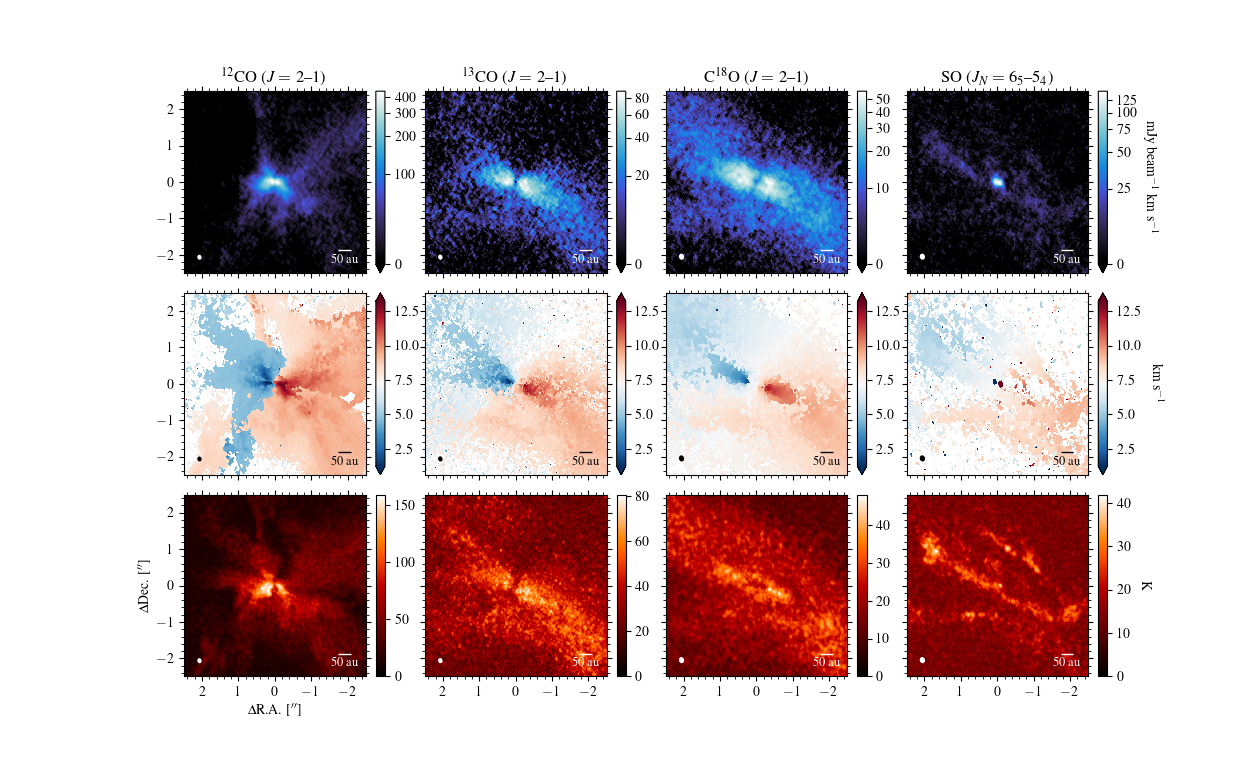

In [23]:
scale = ["large", "zoom"]
rmaxs = {"large": 14, "zoom": 2.5}
scalebar = {"large": 500, "zoom": 50}

for n, s in enumerate(scale):
    fig = plt.figure(figsize=(12.6, 7.6))
    grid = ImageGrid(
        fig,
        rect=111,
        nrows_ncols=(3, 4),
        axes_pad=(0.4, 0.2),
        share_all=True,
        cbar_mode="each",
        cbar_pad=0.1,
    )
    axes = np.array(grid).reshape(3, 4)
    cbar_axes = np.array(grid.cbar_axes).reshape(3, 4)

    for i, m in enumerate(maps):
        for j, line in enumerate(lines):
            ax = axes[i, j]
            imagename = au.VADPpath + au.get_image_basename(
                source, config, line, robust=robust[line]
            ).replace(".fits", "_{}.fits".format(m))

            if m == "M0" and not line == "12CO":
                imagename = imagename.replace("_M0.fits", "_2sigma_M0.fits")

            if m == "v0":
                imagename = imagename.replace("_v0.fits", "_v0_hybridmask.fits")

            map = Map(
                imagename,
                ax=ax,
                data_scaling_factor=data_scaling_factor[m],
                center_coord=center_coord,
                xlim=(-rmaxs[s], rmaxs[s]),
                ylim=(-rmaxs[s], rmaxs[s]),
                set_aspect=True,
                invert_xaxis=False,
            )
            if m == "Fnu":
                map.convert_unit()
            map.plot_colormap(**cmap_kwargs[m])

            cax = cbar_axes[i, j]
            map.add_colorbar(
                cax=cax, label=cbar_label[m] if j == 3 else None, labelpad=15
            )
            map.set_ticker(minor=True, majornticks=5, minornticks=5)
            map.add_beam(color="black" if m == "v0" else "white", fill=True)
            map.add_scalebar(
                scale=scalebar[s] / distance,
                text="{} au".format(scalebar[s]),
                color="black" if m == "v0" else "white",
            )

            if i == 0:
                ax.set_title(eplot.linelabel[line])

    ax.invert_xaxis()
    axes[2, 0].set(xlabel=eplot.RAlabel, ylabel=eplot.Declabel)

    fig.savefig(
        au.figurepath + "map_gallery_{}.pdf".format(s),
        bbox_inches="tight",
        pad_inches=0.01,
    )


In [12]:
fig.savefig(au.figurepath + "map_gallery.pdf", bbox_inches="tight", pad_inches=0.01)

In [9]:
10.5*1.2, 13.5*1.2

(12.6, 16.2)